In [4]:
from bs4 import BeautifulSoup
import requests
import re
import time
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service

options = webdriver.ChromeOptions()
options.add_experimental_option("excludeSwitches", ["enable-automation"])
options.add_experimental_option("useAutomationExtension", False)

### 네이버 뉴스 크롤링

In [5]:
# 입력된 수를 페이지 수에 맞게 만들어주는 함수
# ex) 1page => 1~11 , 2page => 12~21
def makePgNum(num):
    if num == 1:
        return num
    elif num == 0:
        return num + 1
    else:
        return num + 9 * (num - 1)

# 크롤링할 때 page마다 url를 생성해주는 함수
# 키워드는 '라이딩 | 자전거' 로 검색
def makeUrl(start_pg, end_pg):
    if start_pg == end_pg:
        start_page = makePgNum(start_pg)
        # 시작페이지와 끝페이지가 같다면 첫페이지를 유지
        url = "https://search.naver.com/search.naver?where=news&sm=tab_jum&query=%EB%9D%BC%EC%9D%B4%EB%94%A9+%7C+%EC%9E%90%EC%A0%84%EA%B1%B0&start=" + str(
            start_page)
        return url
    else:
        urls = []
        for i in range(start_pg, end_pg + 1):
            page = makePgNum(i)
            # 정상작동했을 때
            url = "https://search.naver.com/search.naver?where=news&sm=tab_jum&query=%EB%9D%BC%EC%9D%B4%EB%94%A9+%7C+%EC%9E%90%EC%A0%84%EA%B1%B0&start=" + str(page)
            urls.append(url)
       
        return urls

In [6]:
page = int(input("\n크롤링할 시작 페이지를 입력해주세요 : "))
print("\n크롤링할 시작 페이지: ", page)

page2 = int(input("\n크롤링할 종료 페이지를 입력해주세요 : ")) 
print("\n크롤링할 종료 페이지: ", page2)

search_urls = makeUrl(page, page2)

driver = webdriver.Chrome(ChromeDriverManager().install())
driver.implicitly_wait(3)

naver_urls = []

# 페이지별 뉴스 본문을 크롤링해주어 가져오는 함수
for i in search_urls:
    driver.get(i)
    time.sleep(1)

    a = driver.find_elements(By.CSS_SELECTOR, 'a.info')

    # 위에서 생성한 css selector list 하나씩 클릭하여 본문 url얻기
    for i in a:
        i.click()

        driver.switch_to.window(driver.window_handles[1])
        time.sleep(3)

        # 네이버 뉴스 url만 가져오기
        url = driver.current_url

        if "news.naver.com" in url:
            naver_urls.append(url)

        else:
            pass

        driver.close()
        # 다시 처음 뉴스페이지탭으로
        driver.switch_to.window(driver.window_handles[0])


# ConnectionError방지
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) Chrome/98.0.4758.102"}

news_content_list = []

# 크롤링한 본문을 select하고 태그를 제거하여 리스트에 담는 함수
for i in naver_urls:
    original_html = requests.get(i, headers=headers)
    html = BeautifulSoup(original_html.text, "html.parser")

    # 뉴스 본문 가져오기
    content = html.select("div#dic_area")

    # 기사 텍스트만 가져오기
    # list합치기
    content = ''.join(str(content))

    # html태그제거
    pattern1 = '<[^>]*>'
    
    content = re.sub(pattern=pattern1, repl='', string=content)
    pattern2 = """[\n\n\n\n\n// flash 오류를 우회하기 위한 함수 추가\nfunction _flash_removeCallback() {}"""
    content = content.replace(pattern2, '')

    news_content_list.append(content)


크롤링할 시작 페이지를 입력해주세요 : 1

크롤링할 시작 페이지:  1

크롤링할 종료 페이지를 입력해주세요 : 50

크롤링할 종료 페이지:  50


C:\Users\Catle_min\AppData\Local\Temp\ipykernel_2632\2794552890.py:9: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())


### 네이버 블로그 크롤링

#### blog_scrapping(url,scroll_num)
  - url: 검색할 url(예: 네이버에 자전거라고 검색한 결과)
  - scroll_num:스크롤 몇 번 넘길건지
 
#### 주의사항
   - 실제로 돌릴 때는내용따오기 파트의 for url in list_href[3:6]를 for url in list_href로 변경

In [7]:
content_list=[]

In [8]:
def blog_scrapping(url,scroll_num):
    driver=webdriver.Chrome('chromedriver.exe')

    # url검색에 라이딩 또는 자전거 검색
    driver.get(url)
    time.sleep(1)
    
    for i in range(0,scroll_num): 
        driver.find_element(By.CSS_SELECTOR,'body').send_keys(Keys.END)
        time.sleep(1)

    soup = BeautifulSoup(driver.page_source, 'html.parser')
    posts =soup.find_all("div", attrs={"class":"total_area"})
    
    # 링크리스트 변수 선언
    list_href = []
    # 전체 게시물을 들어가서 링크를 따온다
    for post in posts:
        post_href = post.select_one('div.total_area > a').get('href')
        list_href.append(post_href)
        
    #내용따오기
    blog_content_list=[]
    for url in list_href:
        content=''
        try:
            driver.get(url)
            # 새로운 창으로 드라이버를 변경해주기 위해서 swirch_to 함수 사용
            # 네이버의 경우 mainFrame을 사용하기에 한번더 frame을 변경
            driver.switch_to.default_content()
            driver.switch_to.frame('mainFrame')
            soup = BeautifulSoup(driver.page_source, 'html.parser')
            blog_contents=soup.find_all("div", attrs={"class":"se-module se-module-text"})
            for blog_content in blog_contents:
                content+=blog_content.get_text()
                # \u200b는 네이버블로그에서 사진 뒤에 붙는 태그?
            content=content.replace('ㅋ','').replace('\u200b','').replace('\n','')
        except:
            pass
        blog_content_list.append(content)
    
    return blog_content_list

In [9]:
search='https://search.naver.com/search.naver?sm=tab_hty.top&where=blog&query=%EB%9D%BC%EC%9D%B4%EB%94%A9+%7C+%EC%9E%90%EC%A0%84%EA%B1%B0&oquery=%EB%9D%BC%EC%9D%B4%EB%94%A9&tqi=h9Bn2dprvxZssiQET8KssssstLd-336687&nso=so%3Ar%2Cp%3A6m'

In [10]:
blog_content_list=blog_scrapping(search,100)

C:\Users\Catle_min\AppData\Local\Temp\ipykernel_2632\3630107167.py:2: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver=webdriver.Chrome('chromedriver.exe')


---

In [11]:
content_list=blog_content_list+news_content_list

---

### 단어빈도시각화 (네이버뉴스,네이버블로그)

In [12]:
from konlpy.tag import Hannanum
hannanum = Hannanum()

In [13]:
temp = []
for i in range(len(content_list)):
    temp.append(hannanum.nouns(content_list[i]))

In [14]:
search_word=['라이딩','자전거','출발','도착'] #stop_word랑 같은 역할
def flatten(l):
    flatList = []
    for elem in l:
        if type(elem) == list:
            for e in elem:
                if e not in search_word:
                    flatList.append(e)
        else:
            if elem not in stop_words:
                    flatList.append(elem)
    return flatList

word_list=flatten(temp)

In [15]:
# 두글자 이상인 단어만 추출
word_list=pd.Series([x for x in word_list if len(x)>1])
word_list.value_counts().head(10)

코스      994
자전거길    771
오늘      632
생각      616
시간      560
정도      555
사진      547
사람      532
시작      512
날씨      499
dtype: int64

In [16]:
from wordcloud import WordCloud
from collections import Counter

font_path = 'NanumBarunGothic.ttf'

wordcloud = WordCloud(
    font_path = font_path,
    width = 800,
    height = 800,
    background_color="white"
)

count = Counter(word_list)
wordcloud = wordcloud.generate_from_frequencies(count)

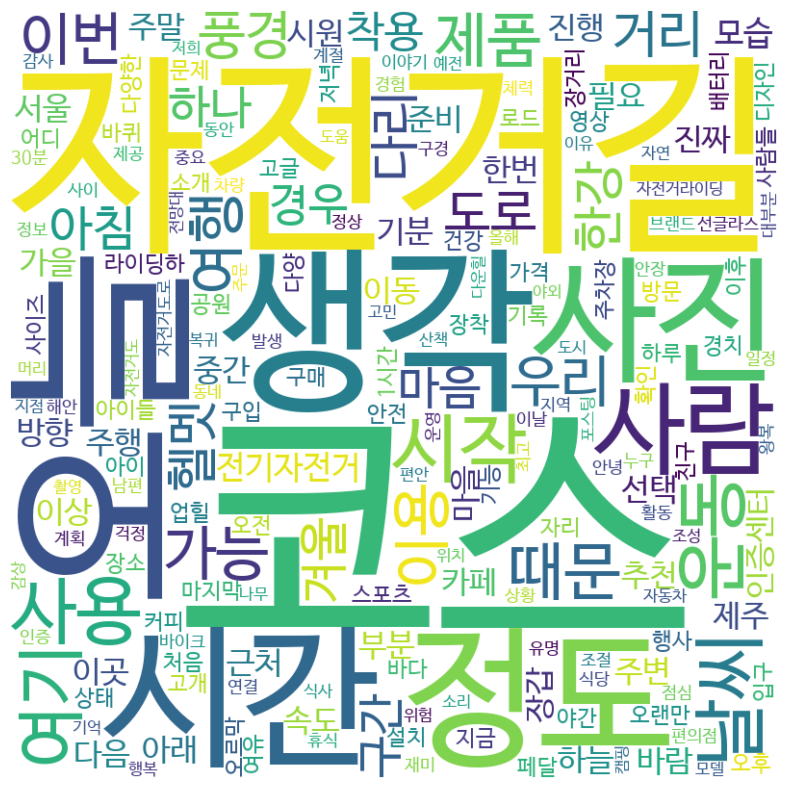

In [17]:
def __array__(self):
    """Convert to numpy array.
    Returns
    -------
    image : nd-array size (width, height, 3)
        Word cloud image as numpy matrix.
    """
    return self.to_array()

def to_array(self):
    """Convert to numpy array.
    Returns
    -------
    image : nd-array size (width, height, 3)
        Word cloud image as numpy matrix.
    """
    return np.array(self.to_image())
array = wordcloud.to_array()


import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(array, interpolation="bilinear")
plt.show()


In [18]:
content_df=pd.DataFrame(content_list)

In [19]:
content_df.to_csv("trend_analysis.csv", index = False)

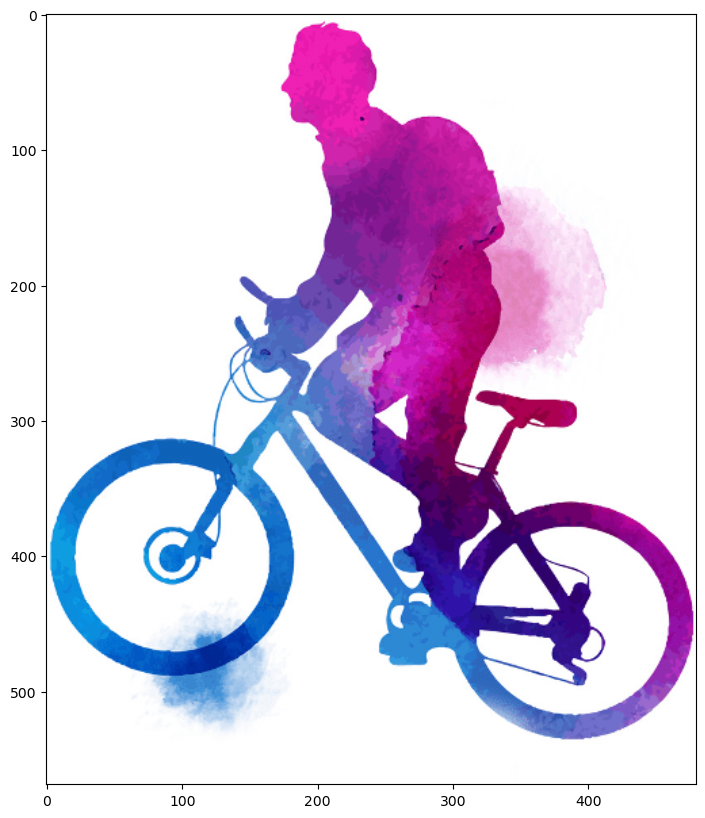

In [20]:
from PIL import Image
import numpy as np
from wordcloud import ImageColorGenerator

bike_img=np.array(Image.open("bike.png"))

plt.figure(figsize=(10,10))
plt.imshow(bike_img,interpolation="bilinear")
plt.show()

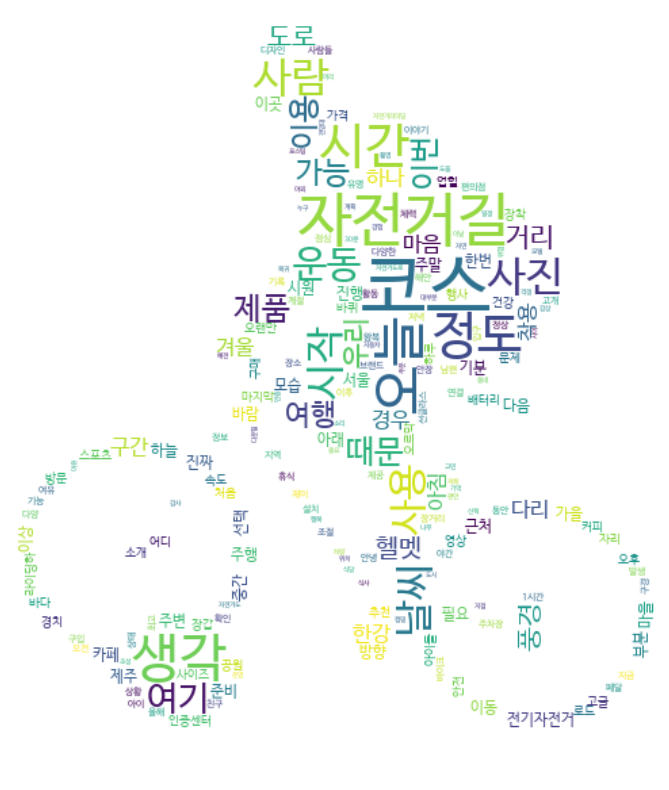

In [21]:
count = Counter(word_list)

wc_moon = WordCloud(
    font_path = font_path,
    mask=bike_img,
    background_color="white"
)
wc_moon = wc_moon.generate_from_frequencies(count)

plt.figure(figsize=(10,10))
plt.imshow(wc_moon,interpolation="bilinear")
plt.axis("off")
plt.show()

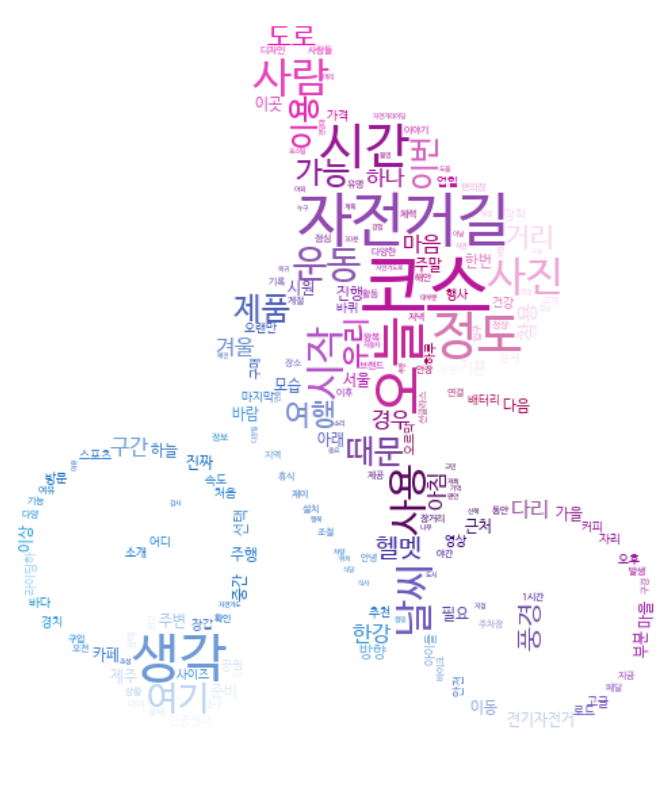

In [22]:
image_colors=ImageColorGenerator(bike_img)

fig=plt.figure(figsize=(10,10))
plt.imshow(wc_moon.recolor(color_func=image_colors),interpolation="bilinear")
plt.axis("off")
plt.show()

In [23]:
fig.savefig('trend_analysis.png')